# Modelo motor retardado libreria control
### *Seleccionar el kernel 'Proyecto control', creado en Anaconda

Creamos la función del motor.

In [32]:
import matplotlib.pyplot as plt   #Importamos librerias.
import numpy as np
import control as co
from control.matlab import rss, lsim
#Definimos las dimensiones de las figuras de formar similar a Matlab
w=7; h=4.8
#Parametros del modelo
R=0.343            # Impedance
L = 0.00018        # Inductance
kb=0.0167          # contraelectromotriz constant
Jm=2.42*10**-6     # Motor inertia
kt=0.0167          # Torque constant
b=5.589458*10**-6

#Matrices de estados: corriente, posición y velocidad.
A=[[-R/L, 0, -kb/L],[0, 0, 1],[kt/Jm, 0, -b/Jm]]   #Matriz de estados.
B=[[1/L],[0],[0]]                                  #Matriz de entradas.
C=[[1, 0, 0],[0, 1, 0],[0, 0, 1]]                  #Matriz de salidas.
D=0                                                #Matriz de transmisión directa.

model=co.ss(A,B,C,D)       #Creamos el modelo en el espacio de estados.
H=co.ss2tf(model)          #Pasamos a función de transferencia.

Aproximación de Pade

In [33]:
delay=1                             #Magnitud del delay
orden= 2                              #Orden de la aproxiamción.
npd, dpd = co.pade(delay, orden)      #Num, Den de tf pade.
pde=co.tf(npd,dpd)                   #Creamos tf Pade del retardo.
#print(pde)

Operamos para obtener la tf del modelo de motor con retardo.

In [34]:
Hpd=H*pde  #tf motor x Pade aproximation
#print(Hpd)
Md=co.tf2ss(Hpd)    #Regresamos de tf a espacio de estados.

Creamos función del motor retardada.

In [35]:
def model_m(A,B,Xi,u,Tl): 
    MA=A    #Matriz de estados del modelo.
    MB=B    #Matriz de entrada
    x=np.reshape(Xi,(5,1))      #estados del modelo.
    x12=MA.dot(x)+MB.dot(u)     # Multiplicación matricial X_dot= A*x+ b*u
    return np.reshape(x12,5) 

Configuración de la simulación.

In [36]:
# Simulation parameters
h= 0.001                        # Time step
t_sim2 = np.arange(0, 5.0, h)   # Simulation time array

# Initial conditions 
x0=np.zeros(len(Md.A))          # Vector de c.i.
u =20* np.ones(len(t_sim2))     # Voltaje input 
Tl = np.zeros_like(t_sim2)      # External torque
x_sim2 = np.zeros((len(t_sim2), len(x0)))  # fill initial condition vector  with zeros
x_sim2[0] = x0                  # Vector of initials conditions of states X

#El vector de salidas y, debe ser congruente con las diemensiones de matriz C.
y=np.zeros((len(t_sim2), 3))    
y[0]=np.array([0, 0, 0])        # Vector of initial outpus

Resolvemos con RKDP

In [37]:
for i in range(1, len(t_sim2)):
    k1=h*model_m(Md.A, Md.B, x_sim2[i-1], u[i-1], Tl[i-1])
    k2=h*model_m(Md.A, Md.B, x_sim2[i-1]+ (k1/5), u[i-1],Tl[i-1])
    k3=h*model_m(Md.A, Md.B, x_sim2[i-1]+ (3/40)*k1 + (9/40)*k2, u[i-1],Tl[i-1])
    k4=h*model_m(Md.A, Md.B, x_sim2[i-1]+ (44/45)*k1 - (56/15)*k2 + (32/9)*k3, u[i-1],Tl[i-1])
    k5=h*model_m(Md.A, Md.B, x_sim2[i-1]+ (19372/6561)*k1 - (25360/2187)*k2 +(64448/6561)*k3 - (212/729)*k4, u[i-1],Tl[i-1])
    k6=h*model_m(Md.A, Md.B, x_sim2[i-1]+ (9017/3168)*k1 -(355/33)*k2 +(46732/5247)*k3 + (49/176)*k4 - (5103/18656)*k5, u[i-1],Tl[i-1])
    k7=h*model_m(Md.A, Md.B, x_sim2[i-1]+ (35/384)*k1 +(500/1113)*k3 +(125/192)*k4 -(2187/6784)*k5 + (11/84)*k6,u[i-1],Tl[i-1])

    x_sim2[i]=x_sim2[i-1]+ (35/384)*k1 + (500/1113)*k3 +(125/192)*k4 -(2187/6784)*k5 +(11/84)*k6
    x_sr=np.reshape(x_sim2[i],(5,1))
    y_sr=Md.C.dot(x_sr)         #Multiplicamos matriz C por los estados X.
    y[i]=np.reshape(y_sr,3)     #Utilizamos reshape para dar la forma adecuada al vector o matriz.

Graficamos las respuestas obtenidas.

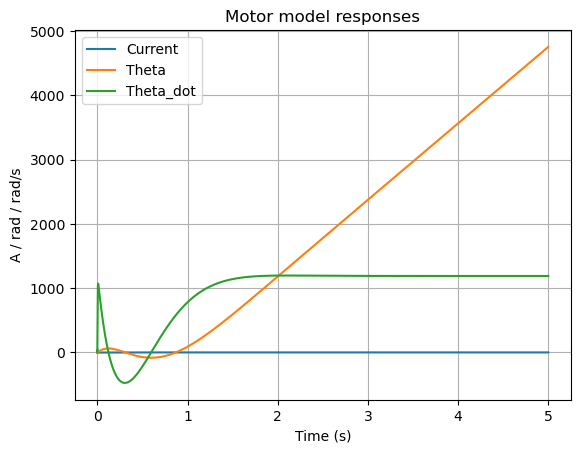

In [38]:
plt.figure()
plt.title('Motor model responses')
plt.plot(t_sim2, y[:, 0], label='Current')  # Plot current
plt.plot(t_sim2, y[:, 1], label='Theta')  # Plot angular position
plt.plot(t_sim2, y[:, 2], label='Theta_dot')  # Plot angular velocity
plt.xlabel('Time (s)')
plt.ylabel('A / rad / rad/s')
plt.legend()
plt.grid(True)
plt.show()

Salida en modo subplot

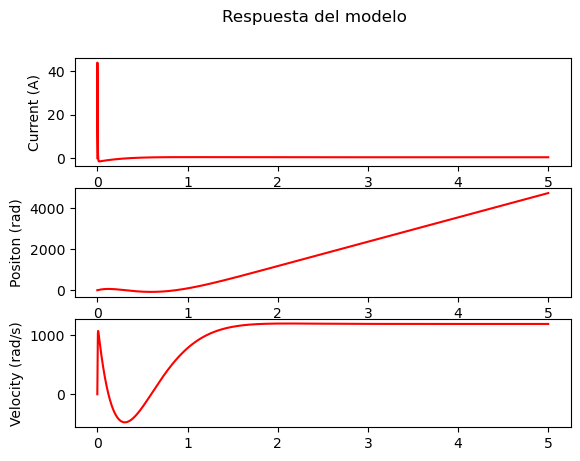

In [39]:
plt.subplot(3,1,1)
plt.plot(t_sim2, y[:, 0], label='Current', color='r')  # Plot current
plt.ylabel('Current (A)')
plt.subplot(3,1,2)
plt.plot(t_sim2, y[:, 1], label='Theta', color='r')  # Plot angular position
plt.ylabel('Positon (rad)')
plt.subplot(3,1,3)
plt.plot(t_sim2, y[:, 2], label='Theta_dot', color='r')  # Plot angular velocity
plt.ylabel('Velocity (rad/s)')
plt.suptitle('Respuesta del modelo')
plt.show()

Guardamos los datos

In [40]:
Dpy=np.array([t_sim2,y[:, 0],y[:, 1],y[:, 2]] )
np.save('Data_py',Dpy)